In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import sys
sys.path.append('/content/gdrive/MyDrive/GSOC_code/updated_data/')



Mounted at /content/gdrive


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import os
import pickle 


from sklearn.utils import shuffle
import random


from sklearn.model_selection import ParameterGrid


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, MaxPool1D, Dropout, BatchNormalization
from tensorflow.keras import regularizers

from tensorflow.keras.layers import Conv1DTranspose, InputLayer
from tensorflow.keras.layers import Reshape, UpSampling1D

from tensorflow.keras.models import Model

from keras import backend as BK


import tensorflow as tf
import tensorflow_probability as tfp



from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import (Dense, Flatten, Reshape, Concatenate, Conv2D, 
                                     UpSampling2D, BatchNormalization)

tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

# Table of contents
1. [Load custom functions](#customfunctions)
2. [Load data](#loaddata)
    <!-- 1. [Sub paragraph](#subparagraph1) -->
3. [Fit AE model](#fitae)
4. [Load saved AE model](#loadae)
5. [Analysis of AE latent space](#latent_space_ae)
6. [Analysis of AE errors](#ae_errors)
7. [Reconstructed spectra](#reconstructions)





# Load custom functions <a name="customfunctions"></a>



In [ ]:
from model_functions import get_ae_encoder, get_ae_decoder, get_autoencoder # VAE specific functions
from model_functions import custom_tanh, add_layer_to_list, get_checkpoint_callback # more general deep learning functions

from analysis_functions import plot_pairplot, ols_backward_elimination, plot_reconstruction, scale_down
from analysis_functions import dump_object

from data_load_new import load_split_pool

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm



# Load data <a name="loaddata"></a>



In [ ]:
directory_list = ['/content/gdrive/MyDrive/GSOC_code/updated_data/data_updated']

data_dict = load_split_pool(1929, "max", pooling_width = 1, scale = False,
                    directory_list = directory_list)

Directory: /content/gdrive/MyDrive/GSOC_code/data_updated Physical properties shape: (2880, 17) Spectral prop shape: (2880, 119921)
Spectral data shape (2880, 119921)
Physical data shape (2880, 17)


In [ ]:
x_train = data_dict["x"]["train"].copy()
x_val = data_dict["x"]["val"].copy()


# Process the datasets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, x_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_val, x_val))

train_dataset = train_dataset.shuffle(1000)

train_dataset = train_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

# Fit AE model  <a name="fitae"></a>


In [ ]:
# Specify custom decoder layer
max_val = data_dict['x']["train"].max().max()
# create custom tanh activation by specifying max value allowed for reconstructions
custom_tanh_activation = lambda x: custom_tanh(x, target_max=max_val)

# UNCOMMENT this if you want to checkpoint:
# checkpoint_filepath_dir = '/content/gdrive/MyDrive/GSOC_code/updated_data/outputs/ae'

epochs = 750

latent_dim = [2]  

hidden_units_layer1 = [256]
hidden_units_layer2 = [128]
hidden_units_layer3 = [None]

# For mparam grid
param_grid = {'latent_dim': latent_dim, 
              'hidden_units_layer1': hidden_units_layer1,
              'hidden_units_layer2': hidden_units_layer2,
              'hidden_units_layer3': hidden_units_layer3,
              }

pg_list = ParameterGrid(param_grid)

In [ ]:
# Define callbacks

# Define a call back for reduction in training rate on plateau
reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=25,
    verbose=0,
    mode="auto",
    min_delta=0.0002,
    cooldown=0,
    min_lr=0,
)

# Define an early stopping callback
earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 50)

# Form callback list to be passed to .fit() method
callbacks = [earlystopping, reduce_learning_rate]

In [ ]:

for model_spec in pg_list:

  # Re-set the weights to random
  BK.clear_session()  

  # Initialise file_name and dense layer list
  file_name = "latent_" + str(model_spec["latent_dim"]) 
  dense_layers = []

  # Append layers if specified
  dense_layers, file_name = add_layer_to_list(dense_layers, file_name, model_spec["hidden_units_layer1"], activation = "relu")
  dense_layers, file_name = add_layer_to_list(dense_layers, file_name, model_spec["hidden_units_layer2"], activation = "relu")
  dense_layers, file_name = add_layer_to_list(dense_layers, file_name, model_spec["hidden_units_layer3"], activation = "relu")

  # Initialise and compile AE model
  ae, ae_encoder, ae_decoder = get_autoencoder(x_train.shape, dense_layers, model_spec["latent_dim"], custom_tanh_activation)

  # Load checkpoint callback (if no filepath suppress error to allow for no checkpoint callback)
  try:
    checkpoint_callback, checkpoint_filepath = get_checkpoint_callback(checkpoint_filepath_dir, file_name)
    # UNCOMMENT this if you want to checkpoint:
    # callbacks.append(checkpoint_callback)
    print("File name:", file_name)
    print("Checkpoint path:", checkpoint_filepath)
  except:
    pass

  # Fit model with required callbacks
  ae_history = ae.fit(train_dataset, validation_data=test_dataset, epochs=epochs, 
                        callbacks = callbacks)




Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               30700032  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
encoding_layer (Dense)       (None, 2)                 258       
Total params: 30,733,186
Trainable params: 30,733,186
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 128)               384       
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024     
_________________

KeyboardInterrupt: ignored

# Load saved AE model <a name="loadae"></a>


In [ ]:
results = dict()


checkpoint_filepath_dir = '/content/gdrive/MyDrive/GSOC_code/updated_data/outputs/ae'


# Specify custom decoder layer
max_val = data_dict['x']["train"].max().max()
# create custom tanh activation by specifying max value allowed for reconstructions
custom_tanh_activation = lambda x: custom_tanh(x, target_max=max_val)

epochs = 750

latent_dim = [1, 2, 3, 4, 5, 8, 10]  

hidden_units_layer1 = [256]
hidden_units_layer2 = [128]
hidden_units_layer3 = [None]

# Form parameter grid
param_grid = {'latent_dim': latent_dim, 
              'hidden_units_layer1': hidden_units_layer1,
              'hidden_units_layer2': hidden_units_layer2,
              'hidden_units_layer3': hidden_units_layer3}

pg_list = ParameterGrid(param_grid)

In [ ]:
for model_spec in pg_list:

  # Re-set the weights to random
  BK.clear_session()  

  # Initialise file_name and dense layer list
  file_name = "latent_" + str(model_spec["latent_dim"]) 
  dense_layers = []

  # Append layers if specified
  dense_layers, file_name = add_layer_to_list(dense_layers, file_name, model_spec["hidden_units_layer1"], activation = "relu")
  dense_layers, file_name = add_layer_to_list(dense_layers, file_name, model_spec["hidden_units_layer2"], activation = "relu")
  dense_layers, file_name = add_layer_to_list(dense_layers, file_name, model_spec["hidden_units_layer3"], activation = "relu")

  # Initialise and compile AE model
  ae, ae_encoder, ae_decoder = get_autoencoder(x_train.shape, dense_layers, model_spec["latent_dim"], custom_tanh_activation)

  # Load checkpoint callback
  checkpoint_callback, checkpoint_filepath = get_checkpoint_callback(checkpoint_filepath_dir, file_name)

  # if file does not exist, skip the load and print a message "failed to load"
  try: 

    ae.load_weights(checkpoint_filepath)
    
    reconstr = ae.predict(x_val)   # reconstruction of validation set
    reconstr_loss = (( reconstr.ravel() - x_val.ravel())**2 ).sum() /x_val.size # reconstruction MSE

    # Save to "results" dictionary
    results[file_name] = dict()
    results[file_name]["latent_dim"] = model_spec["latent_dim"]
    results[file_name]["model_spec"] = model_spec
    results[file_name]["loss"] = reconstr_loss

    results[file_name]["x_val_reconstruction"] = reconstr
    results[file_name]["x_val_encoded"] = ae_encoder(x_val).numpy()

    print(file_name, "loaded and added to the dictionary." )
    print("Loss:", reconstr_loss)

  except:
    print(file_name, "failed to load." )


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               30700032  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
encoding_layer (Dense)       (None, 1)                 129       
Total params: 30,733,057
Trainable params: 30,733,057
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 128)               256       
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024     
_________________

In [ ]:
# Save the dictionatry containing results
location = '/content/gdrive/MyDrive/GSOC_code/updated_data/outputs/ae'
filename = "results_ae"
# UNCOMMENT this if you want to overwrite results:
# dump_object(results, location, filename)

()

# Analysis of AE latent space <a name="latent_space_ae"></a>


In [ ]:
with open('/content/gdrive/MyDrive/GSOC_code/updated_data/outputs/ae/results_ae', 'rb') as f:
    dict_loaded_ae = pickle.load(f)

In [ ]:
y_train_df = pd.DataFrame(data_dict["y"]["train"], columns = data_dict['physical_col_names'])
y_train_df["angle_diff1"] = y_train_df['halo_unit_vector1'] - y_train_df['ray_unit_vector1']
y_train_df["angle_diff2"] = y_train_df['halo_unit_vector2'] - y_train_df['ray_unit_vector2']
y_train_df.drop(['bad_trajectories', 'zero_length', 'ray_number', 'halo_unit_vector1',
       'halo_unit_vector2', 'halo_unit_vector3', 'ray_unit_vector1',
       'ray_unit_vector2', 'ray_unit_vector3'], axis = 1, inplace = True)
# y_train_df["angle_diff1"] = y_train_df['halo_unit_vector1'] - y_train_df['ray_unit_vector1']
# y_train_df["angle_diff2"] = y_train_df['halo_unit_vector2'] - y_train_df['ray_unit_vector2']

In [ ]:
y_val_df = pd.DataFrame(data_dict["y"]["val"], columns = data_dict['physical_col_names'])
y_val_df["angle_diff1"] = y_val_df['halo_unit_vector1'] - y_val_df['ray_unit_vector1']
y_val_df["angle_diff2"] = y_val_df['halo_unit_vector2'] - y_val_df['ray_unit_vector2']
y_val_df.drop(['bad_trajectories', 'zero_length', 'ray_number', 'halo_unit_vector1',
       'halo_unit_vector2', 'halo_unit_vector3', 'ray_unit_vector1',
       'ray_unit_vector2', 'ray_unit_vector3'], axis = 1, inplace = True)

In [ ]:
selected_ae_model = "latent_4_dense_256_dense_128"

x_val_encoded_ae = pd.DataFrame( dict_loaded_ae[selected_ae_model]['x_val_encoded'].copy() )
x_val_reconstruction_ae = dict_loaded_ae[selected_ae_model]['x_val_reconstruction'].copy()

In [ ]:
# Form other useful datasets (for plotting & models)

# merge encoded spectra and physical properties
merged_encoded_phys_ae = pd.merge(  x_val_encoded_ae, y_val_df, left_index = True, right_index = True)
# select only zero-impact spectra
merged_encoded_phys_ae_zero_impact = merged_encoded_phys_ae[merged_encoded_phys_ae["impact_param"] == 0]
# select only non-zero impact spectra
merged_encoded_phys_ae_nonzero_impact = merged_encoded_phys_ae[merged_encoded_phys_ae["impact_param"] != 0]

merged_encoded_phys_ae["zero_impact"] = merged_encoded_phys_ae["impact_param"] == 0

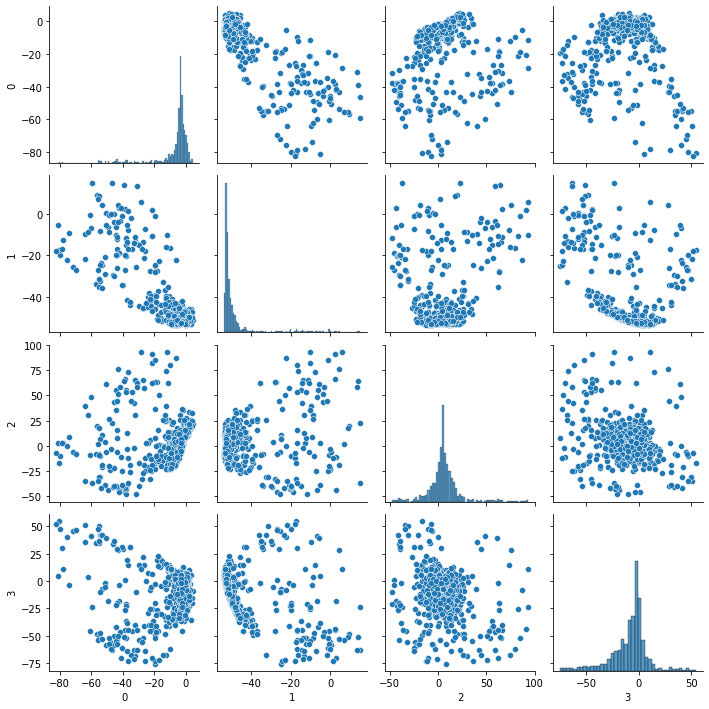

In [ ]:
sns.pairplot( x_val_encoded_ae  )

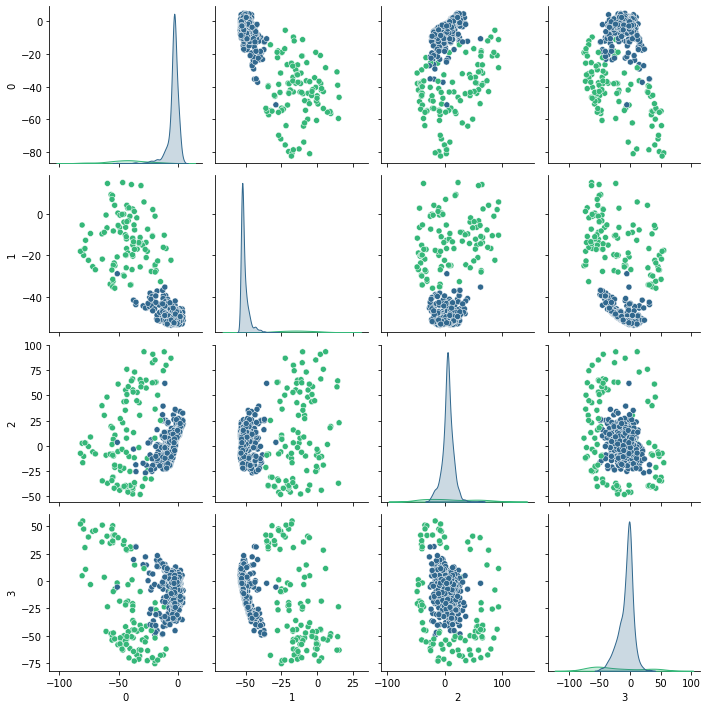

In [ ]:
f = sns.pairplot(merged_encoded_phys_ae, vars = [0, 1, 2, 3], hue = "zero_impact", palette = "viridis")
f._legend.remove()

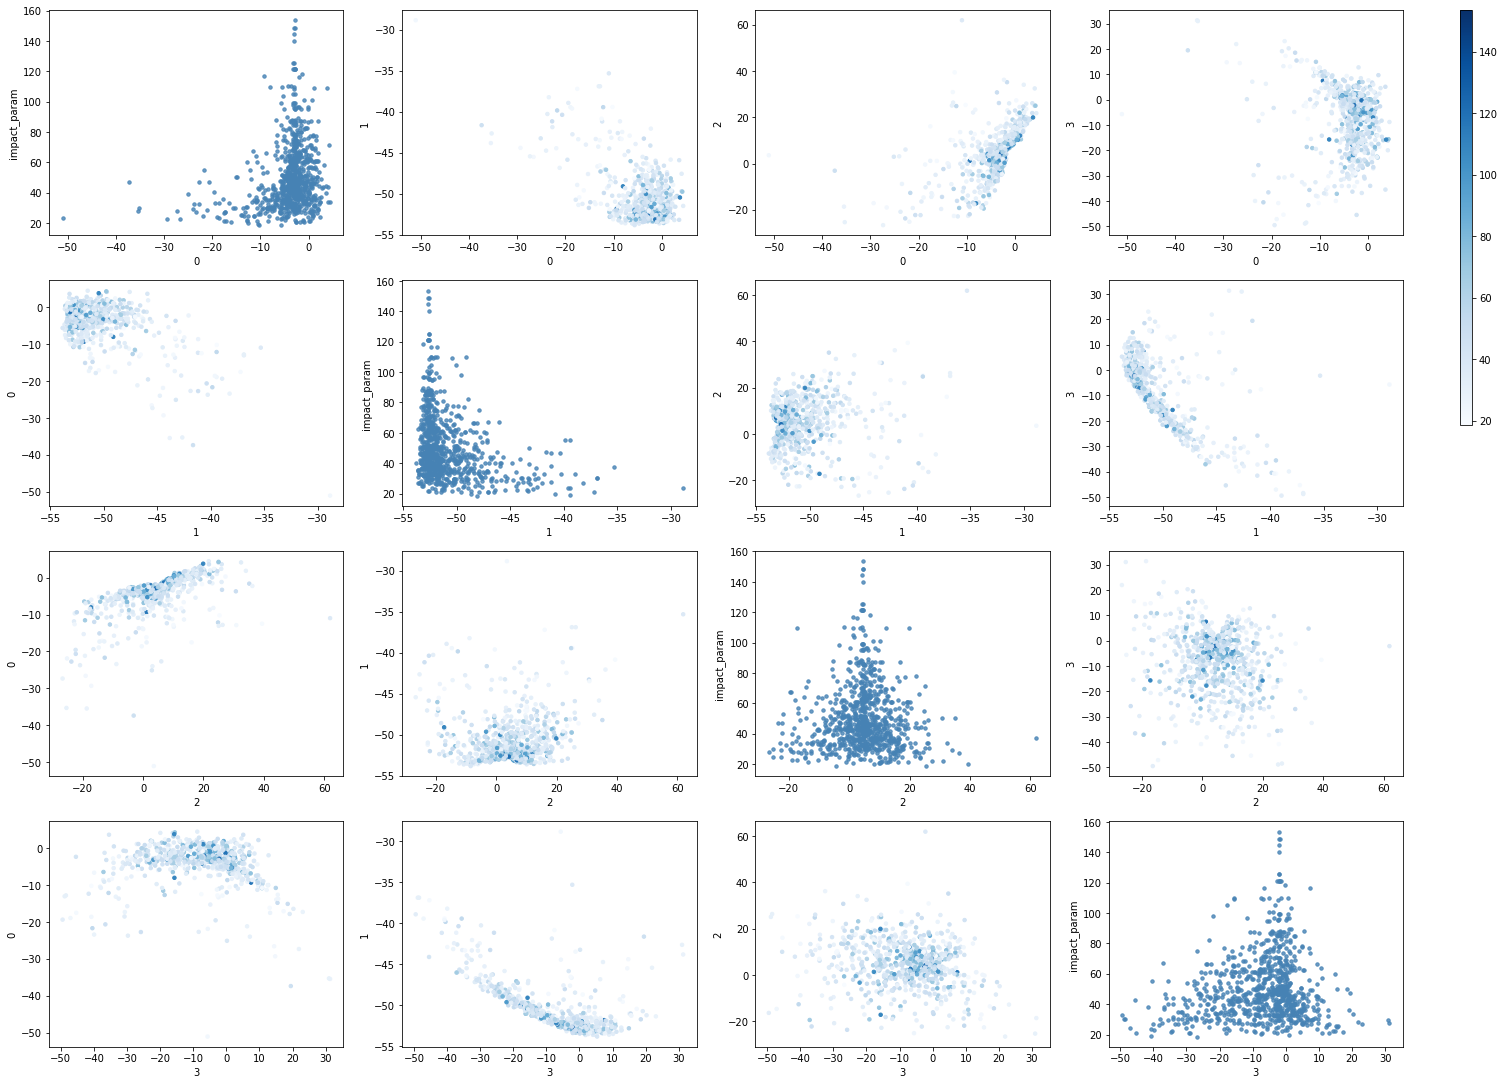

In [ ]:
vars = [0, 1, 2, 3]

plot_pairplot(df =  merged_encoded_phys_ae_nonzero_impact, vars = vars, hue_var = "impact_param", cmap_scheme = "Blues", scatter_colour = "steelblue");

In [ ]:
# Relating physical parameters and latent space for Zero-impact spectra

from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

poly = PolynomialFeatures(interaction_only=False, include_bias = False)

# select latent feature
# latent_feature = 0


dict_elimination_nonzero_impact_ae = dict()

# Physical properties of interest
X_input = merged_encoded_phys_ae_zero_impact.loc[:, ['impact_param', 'r_v', 'stellar_radius', 'circularity', 'angle_diff1', 'angle_diff2']]
# Add interactions and squares of all variables
X_interactions = poly.fit_transform(X_input)
# get names of new variables for better interpretability
interaction_names = poly.get_feature_names(X_input.columns)
# Form an extended dataframe
X_interactions_df = pd.DataFrame(X_interactions, columns = interaction_names)


In [ ]:
# Dictionary to store results
dict_elimination_nonzero_impact_ae = dict()
# Loop through latent features
for i in range(4):

  dict_elimination_nonzero_impact_ae[str(i)] = dict() # initialise sub-dict. 
  # latent feature:
  Y = merged_encoded_phys_ae_zero_impact.iloc[:,i].copy()
  Y = np.array(Y).reshape(-1,1)
  # explanatory variables (physical properties + their interactions + their squares)
  X = X_interactions_df.copy() 
  scaler_x = StandardScaler()
  # scale the variables (standardisations only changes coefficients, but makes interpretability easier)
  X_scaled = scaler_x.fit_transform(X)

  # Backward elimination to find the most important features
  r, f, r2_adj = ols_backward_elimination(Y, X = X_scaled, X_columns = X_interactions_df.columns)
  # store results
  dict_elimination_nonzero_impact_ae[str(i)]["r_squared"] = r
  dict_elimination_nonzero_impact_ae[str(i)]["features"] = f  
  dict_elimination_nonzero_impact_ae[str(i)]["r_asquared_adj"] = r2_adj 

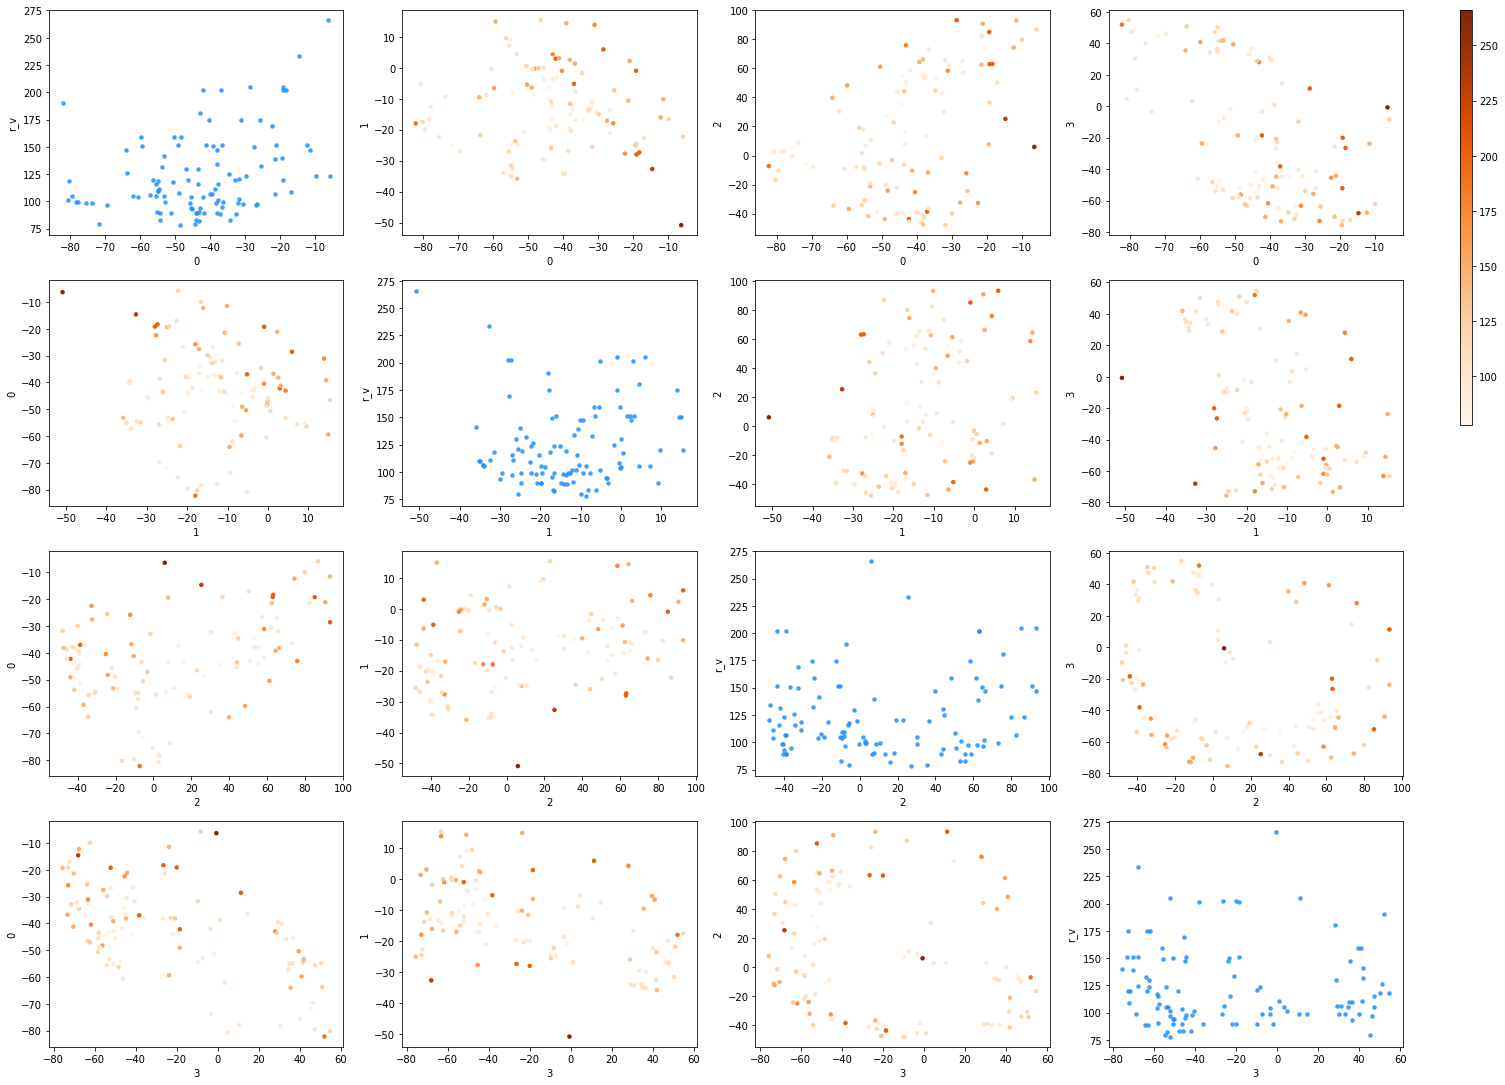

In [ ]:
vars = [0, 1, 2, 3]

plot_pairplot(df =  merged_encoded_phys_ae_zero_impact, vars = vars, hue_var = "r_v", cmap_scheme = "Oranges", log = False);

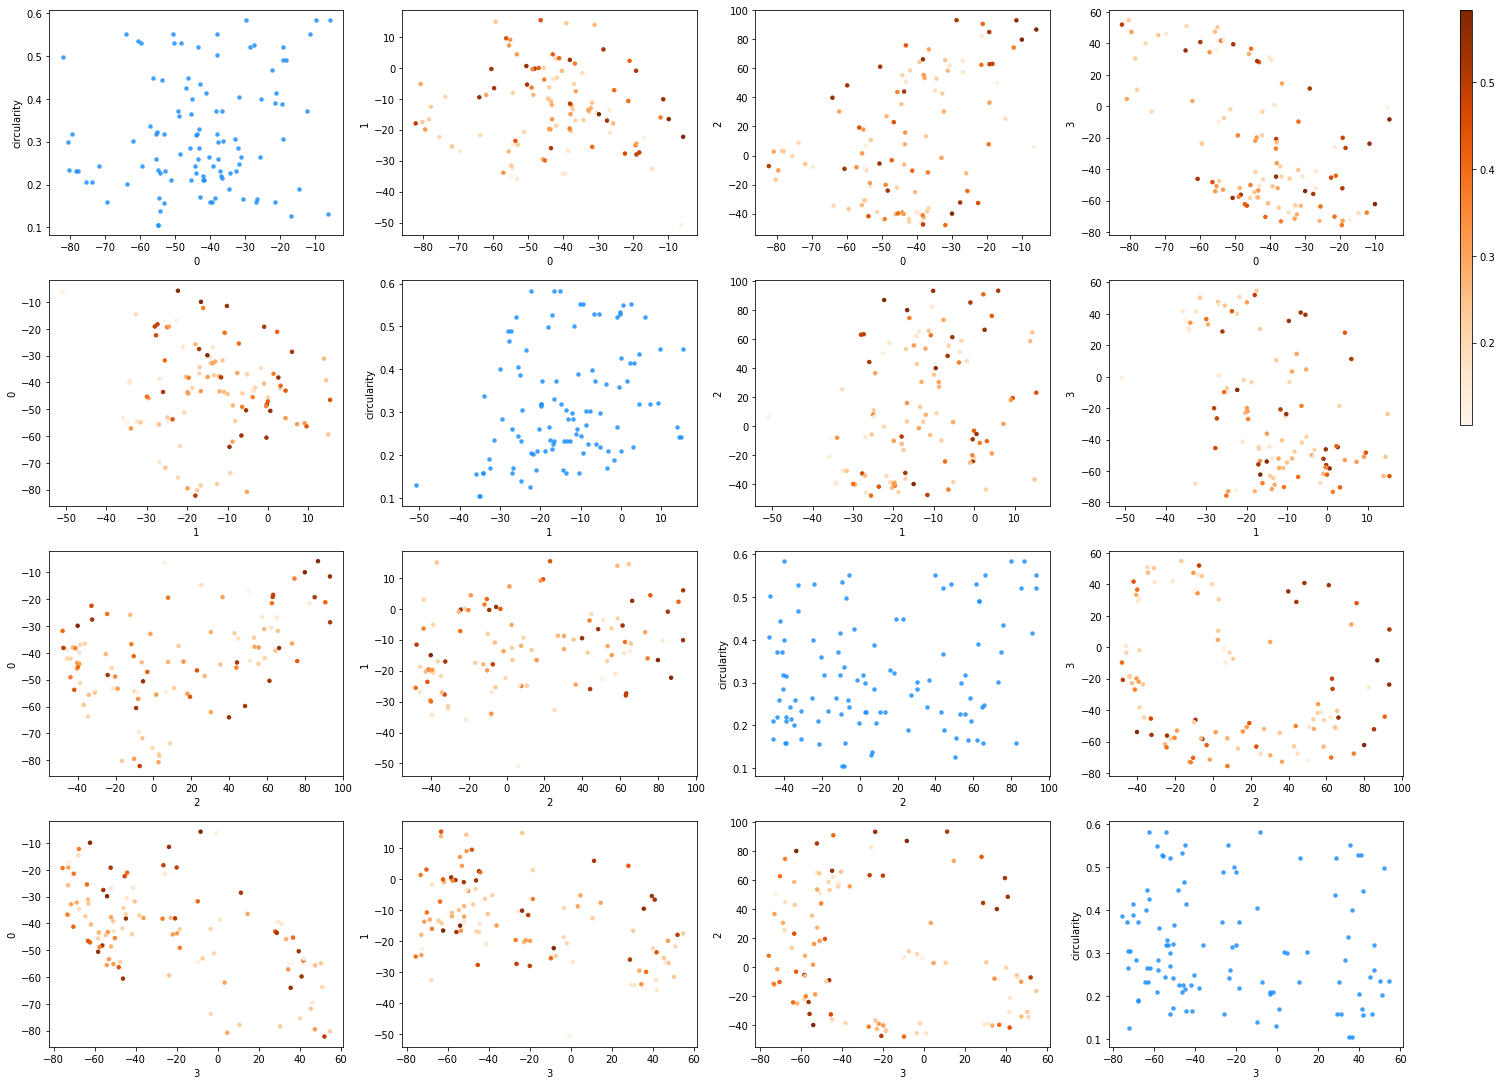

In [ ]:
vars = [0, 1, 2, 3]

plot_pairplot(df =  merged_encoded_phys_ae_zero_impact, vars = vars, hue_var = "circularity", cmap_scheme = "Oranges", log = False);

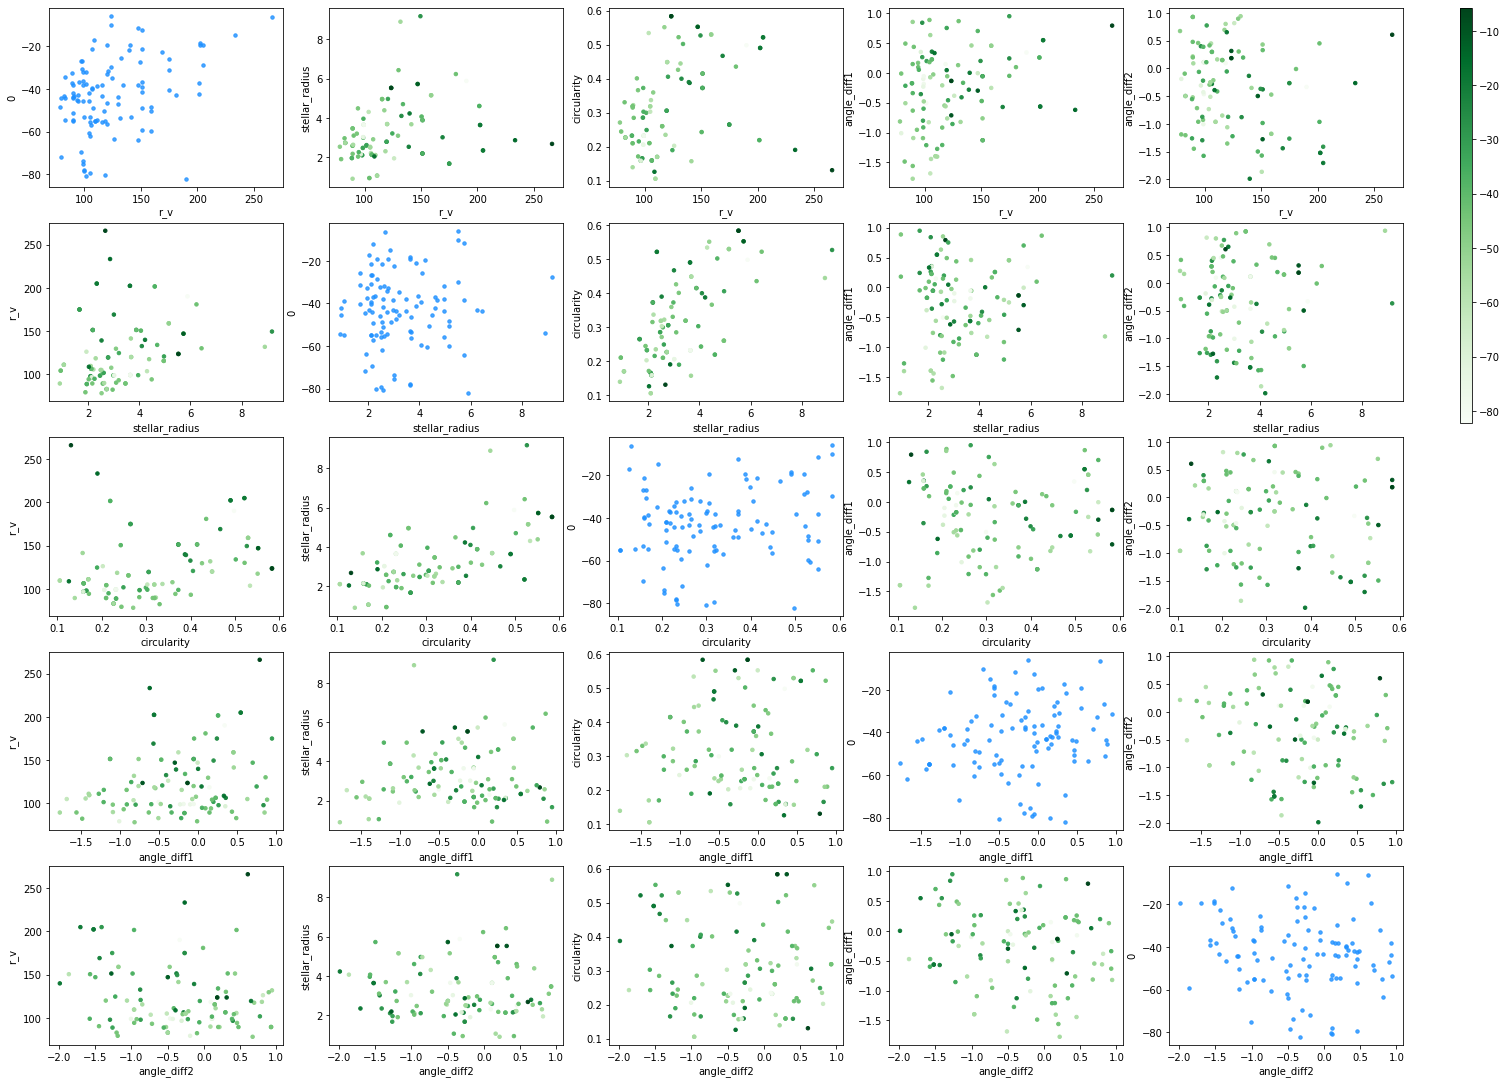

In [ ]:
vars = ['r_v', 'stellar_radius', 'circularity', "angle_diff1", "angle_diff2"]

plot_pairplot(df =  merged_encoded_phys_ae_zero_impact, vars = vars, hue_var = 0, cmap_scheme = "Greens");

# Analysis of AE errors <a name="ae_errors"></a>


In [ ]:
vae_error = (x_val - x_val_reconstruction_ae )
total_flux_per_sample = np.abs(data_dict["x"]["val"]-1).sum(axis = 1)

Text(0, 0.5, 'CDF')

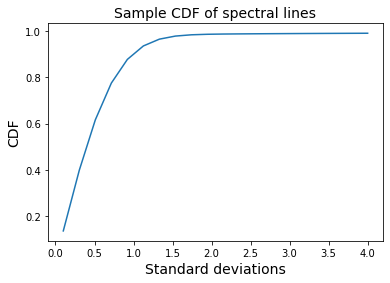

In [ ]:
# Plot sample CDF of spectral lines, based on varying threshold in terms of standard deviation

x_val_demean = (data_dict["x"]["val"] - data_dict["x"]["val"].mean())
std_val = data_dict["x"]["val"].std()

std_seq = np.linspace(0.1, 4, 20)
proportion_list = []
sum_list = list()

for std_margin in std_seq:
    
    proportion = (np.abs(x_val_demean) < std_margin*std_val).mean()
    sum_spectra = (np.abs(x_val_demean) < std_margin*std_val).sum()
    proportion_list.append(proportion)
    sum_list.append(sum_spectra)
    
fig,ax = plt.subplots()
ax.plot(std_seq, proportion_list)
ax.set_xlabel("Standard deviations", fontsize = 14)
ax.set_title("Sample CDF of spectral lines", fontsize = 14)
ax.set_ylabel("CDF", fontsize = 14)

In [ ]:
# Based on the plot above select thresholds = 1 standard deviation
# Now identify signal and noise based on this

x_std, total_flux, noise, signals = scale_down(data_dict["x"]["train"], 1)
x_std_val,total_flux_val, noise_val, signals_val  = scale_down(
    data_dict["x"]["val"], 1, x_std = x_std)

In [ ]:
# Calculate additional quantities
# total_flux_train = np.abs(x_train-1).sum(axis = 1) # total volume of spectral lines
signal_original_val = np.abs(x_val) * signals_val # signal lines

total_signal_val = np.abs(signal_original_val-1).sum(axis = 1) # total signal volume
total_flux_val = np.abs(x_val-1).sum(axis = 1) # total volume of spectral lines

scaled_errors = np.abs((vae_error)).sum(axis = 1) /(total_flux_val) # scale error by the amount of signal in the original spectrum

Text(0.5, 1.0, 'Reconstruction error vs spectral std')

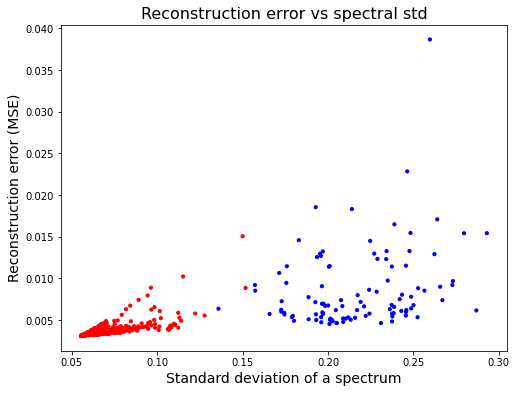

In [ ]:
std_val = data_dict["x"]["val"].std(axis = 1)

fig, ax = plt.subplots(figsize = (8, 6))
sct = ax.scatter(std_val, (np.abs(vae_error)**2).mean(axis = 1) , s = 10, c = (y_val_df["impact_param"] != 0), 
           cmap = "bwr")

ax.set_xlabel("Standard deviation of a spectrum", fontsize = 14)
ax.set_ylabel("Reconstruction error (MSE)" , fontsize = 14)

ax.set_title("Reconstruction error vs spectral std", fontsize = 16)


Text(0.5, 1.0, 'Relative reconstruction error vs total flux')

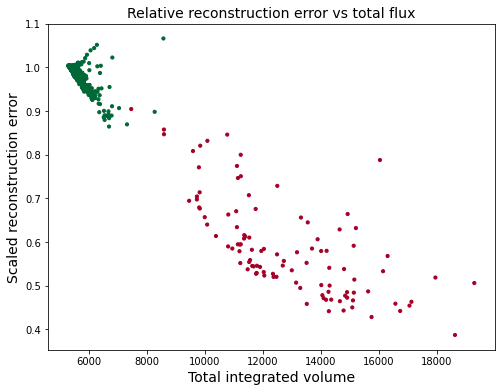

In [ ]:
fig, ax = plt.subplots(figsize = (8, 6))
ax.scatter(total_flux_val, scaled_errors , s = 10, c = (y_val_df["impact_param"] != 0), cmap = "RdYlGn" )
ax.set_xlabel("Total integrated volume", fontsize = 14)
ax.set_ylabel("Scaled reconstruction error" , fontsize = 14)
# ax.legend()
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_title("Relative reconstruction error vs total flux",fontsize = 14)
# ax.set_ylim([0.2, 1.1])



# Reconstructed spectra <a name="reconstructions"></a>

()

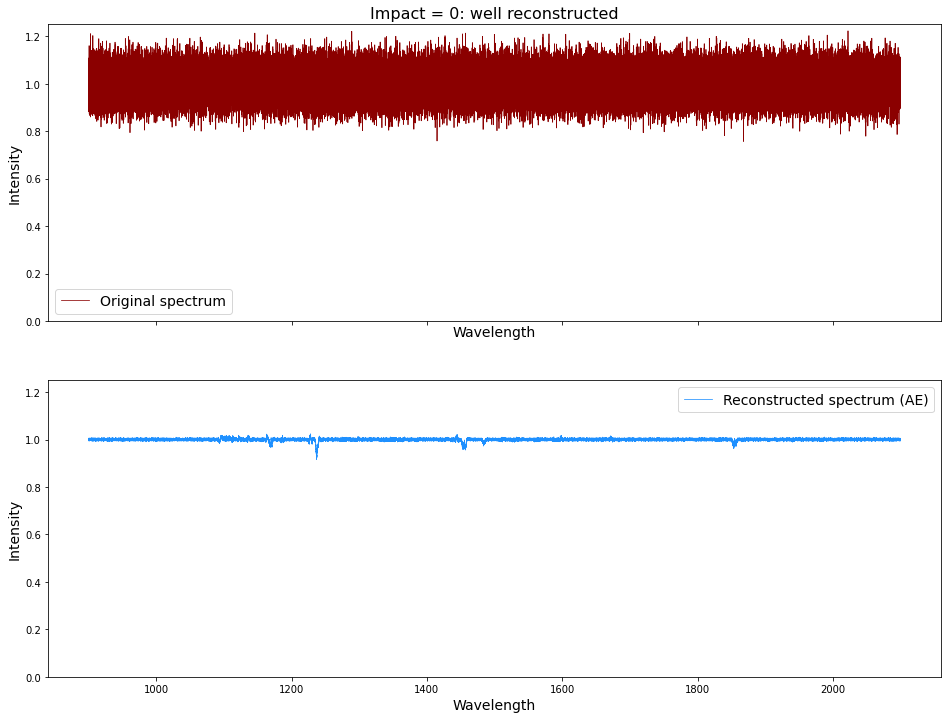

In [ ]:
plot_reconstruction(data_dict["wavelengths"], x_val_reconstruction_ae, x_val, 584, col_original = "darkred", col_reconstr = "dodgerblue", model_name = "AE", title = "Impact = 0: well reconstructed")

()

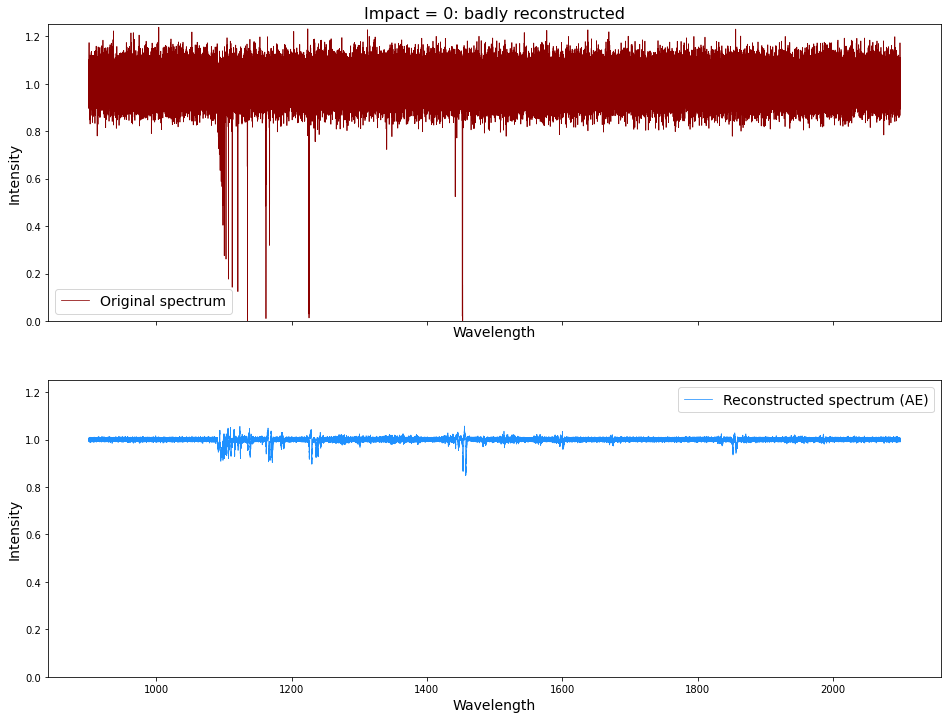

In [ ]:
plot_reconstruction(data_dict["wavelengths"], x_val_reconstruction_ae, x_val, 390, col_original = "darkred", col_reconstr = "dodgerblue", model_name = "AE", title = "Impact = 0: badly reconstructed")

()

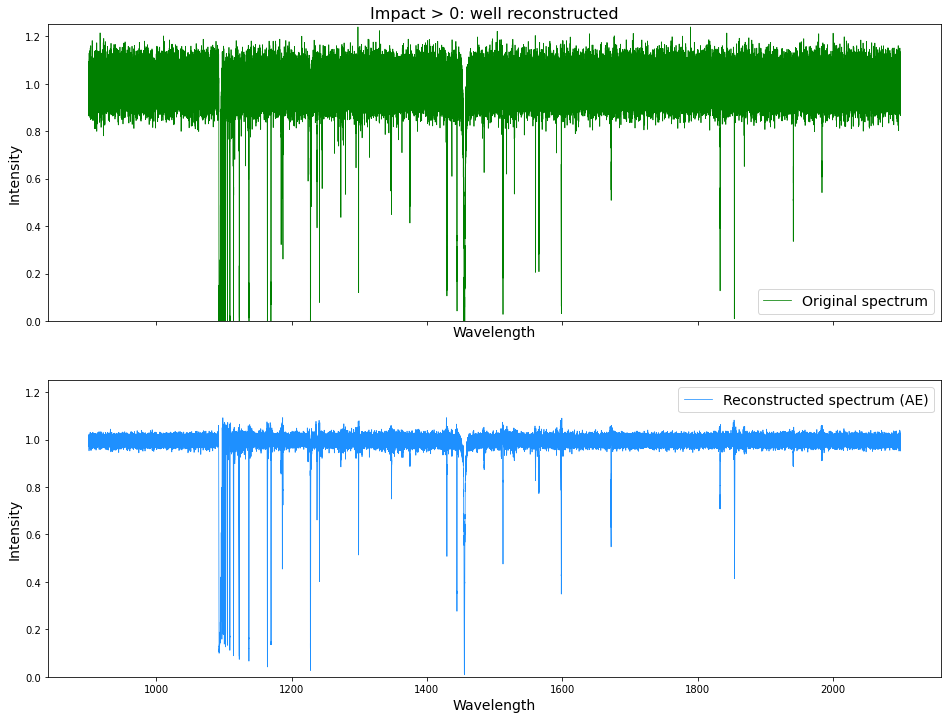

In [ ]:
plot_reconstruction(data_dict["wavelengths"], x_val_reconstruction_ae, x_val, 309, col_original = "Green", col_reconstr = "dodgerblue", model_name = "AE", title = "Impact > 0: well reconstructed")

()

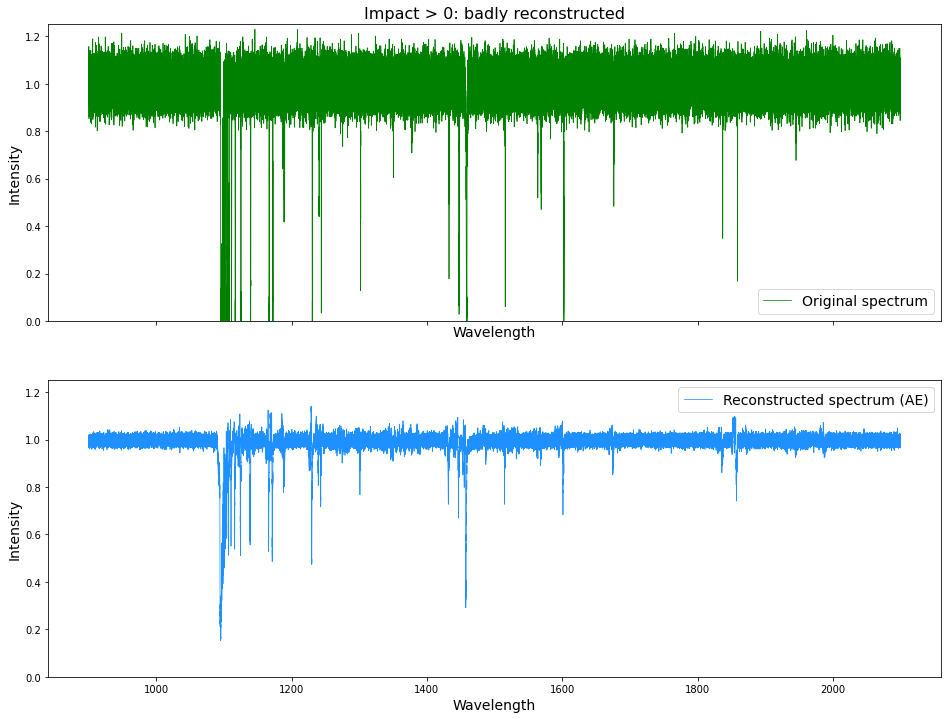

In [ ]:
plot_reconstruction(data_dict["wavelengths"], x_val_reconstruction_ae, x_val, 124, col_original = "Green", col_reconstr = "dodgerblue", model_name = "AE", title = "Impact > 0: badly reconstructed")

()

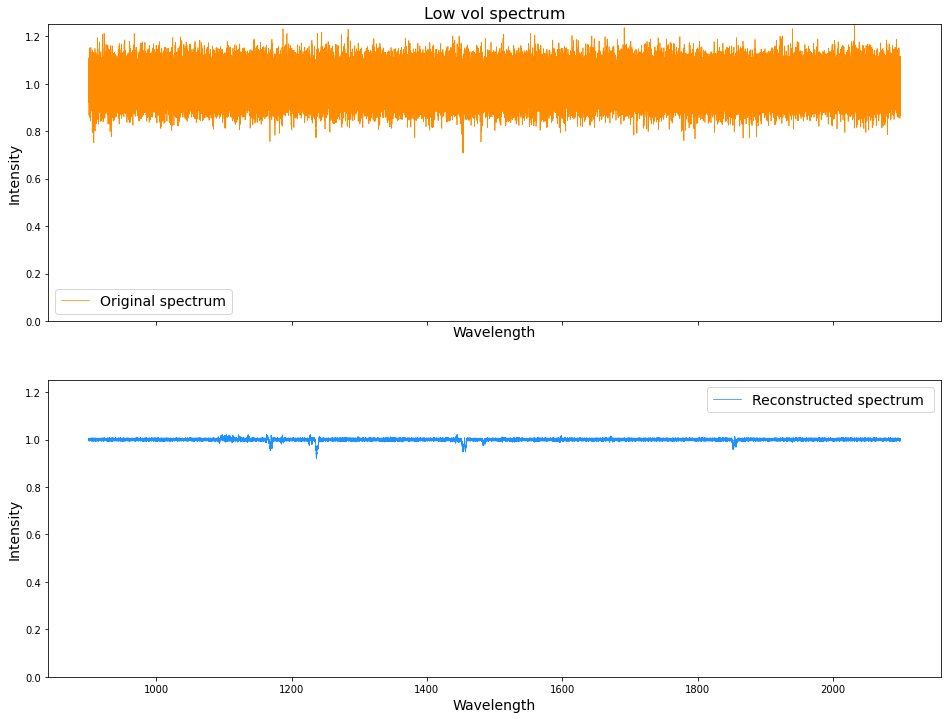

In [ ]:
plot_reconstruction(data_dict["wavelengths"], x_val_reconstruction_ae, x_val, 102, col_original = "darkorange", col_reconstr = "dodgerblue", title = "Low vol spectrum")